In [31]:
# Restart the kernel
import os
current_dir ='../../../'
os.chdir(current_dir)

In [32]:
from src.codes.basic import *
from src.codes.utils import *

from src.codes.prob_classes.base_class_heat_conduction import FOS_FEM
from src.codes.prob_classes.base_class_heat_conduction import probdata

import src.codes.reductor.rom_class as rom_class
from src.codes.algorithms.ecsw import ecsw_red
from importlib import reload

### class for data (geometry, material property, mesh)

In [33]:
nref= [3,3,3]
L = [10.,12.,14.]

mat_layout = np.zeros((4,4,4),dtype=int)
src_layout = np.zeros((4,4,4),dtype=int)

# src_layout[0,0,0] = 1
# src_layout[1,1,1] = 1
# src_layout[2,2,2] = 1
# src_layout[3,3,3] = 1

In [34]:
fdict = {}

cond_list = []
cond_list.append( lambda T,mu: mu*T + 100. + 0.*T )
fdict["cond"] = cond_list

dcond_list = []
dcond_list.append( lambda T,mu: mu + 0. + 0.*T )
fdict["dcond"] = dcond_list

qext_list = []
qext_list.append( lambda T,mu: 0.0+100.0 + 0.*T )
fdict["qext"] = qext_list

dqext_list = []
dqext_list.append( lambda T,mu: 0.0 + 0.*T)
fdict["dqext"] = dqext_list

In [35]:
bc = {}
bc['x_min']={'type':'dirichlet','value':0.}
bc['x_max']={'type':'dirichlet','value':0.}
bc['y_min']={'type':'dirichlet','value':0.}
bc['y_max']={'type':'dirichlet','value':0.}
bc['z_min']={'type':'dirichlet','value':0.}
bc['z_max']={'type':'dirichlet','value':0.}

### Simulate FOS

In [36]:
random.seed(25)
params = np.r_[1.:4.0:0.01]
quad_deg = 3
N_snap = 15 # Training Snapshots
NL_solutions = []
param_list = []
K_mus = []
q_mus = []


 Snap 0


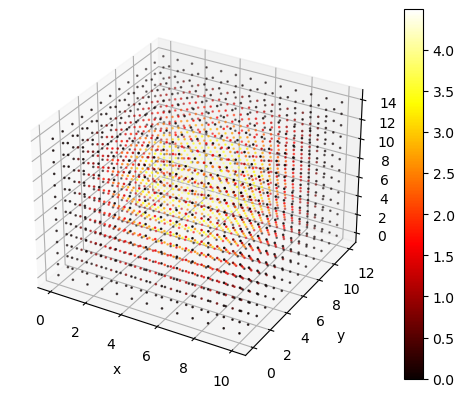


 Snap 1


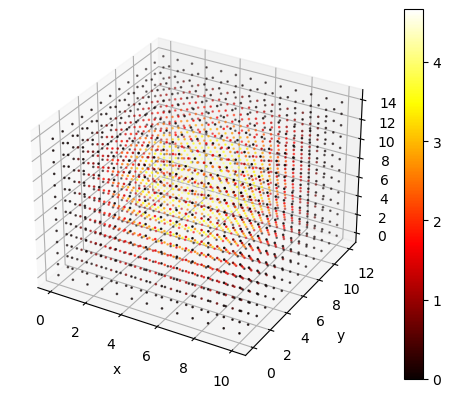


 Snap 2


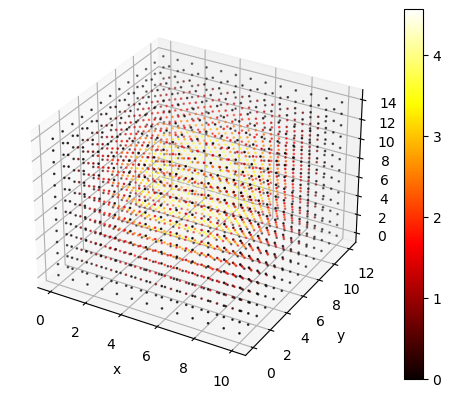


 Snap 3

 Snap 4

 Snap 5

 Snap 6

 Snap 7

 Snap 8

 Snap 9

 Snap 10

 Snap 11

 Snap 12

 Snap 13

 Snap 14


In [37]:
for i in range(N_snap):
    print(f"\n Snap {i}")
    param = random.choice(params) # Choose from parameter list
    param_list.append(param)
    
    if i==0:
        d = probdata(bc, mat_layout, src_layout, fdict, nref, L, param, pb_dim=3)
        FOS = FOS_FEM(d,quad_deg)
    else:
        FOS.mu = param
    T_init = np.zeros(d.n_verts) + 4.0
    NL_solution_p, Ke, rhs_e, mask = solve_fos(FOS, T_init)
    NL_solutions.append(NL_solution_p.flatten())
    K_mus.append(Ke)
    q_mus.append(rhs_e)
    if i<3:
        plot3D(d.xi[0], d.xi[1], d.xi[2], NL_solution_p, hmap=True)

In [38]:
NLS = np.asarray(NL_solutions)
np.shape(NLS)

(15, 2197)


### ECSW Hyper-reduction
#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

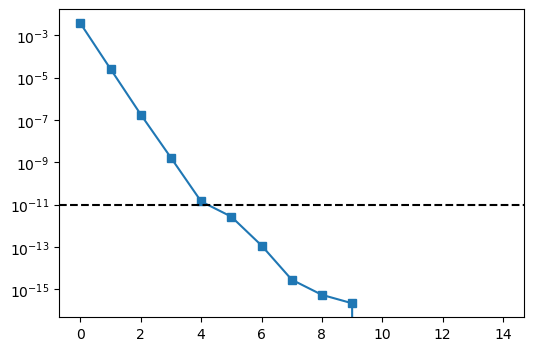

In [39]:
n_sel, U = svd_mode_selector(NL_solutions, tol_f=1e-11)
V_sel = U[:, :n_sel]

In [40]:
# for i in range(n_sel):
#     plot3D(d.xi[0],d.xi[1],d.xi[2],V_sel[:,i],hmap=True)

 
#### Step2: ECSW

In [41]:
tic_h_setup_b = time.time()
tol = 1e-10
xi, residual = ecsw_red(d, V_sel, d.Le, K_mus, q_mus, n_sel, N_snap, mask,NL_solutions,tol=tol)
toc_h_setup_b = time.time()

In [42]:
print(f"this is the residual from fnnls: {residual}")

this is the residual from fnnls: 8.273107871364166e-06


In [43]:
colors = ['red' if value > 0 else 'blue' for value in xi]
sizes = [15 if value > 0 else 1 for value in xi]

In [44]:
mask_xi = xi>0

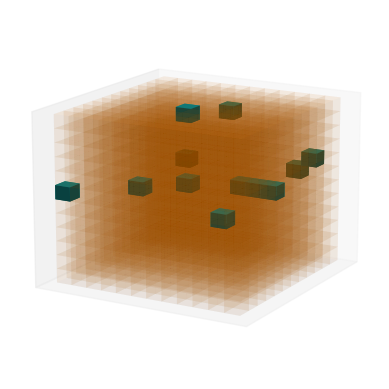

In [45]:
# It appears that the variable grid_size was lost. Let's define it again along with the required libraries.
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Define the grid size as 20x20x20 for the 3D grid
grid_size = (d.ncells[0], d.ncells[1], d.ncells[2])


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define some specific cells to have different transparency within the cube
# Using (x, y, z, alpha) where alpha is the transparency level (0.0 to 1.0)
# specific_cells = [(5, 5, 5, 1.0), (10, 10, 10, 1.0), (15, 15, 15, 1.0)]

# Draw the 3D grid and color the cells
for x in range(grid_size[0]):
    for y in range(grid_size[1]):
        for z in range(grid_size[2]):  # Using depth as the third dimension
            alpha_value = 0.1/2  # Default transparency
            clr = (1, 0.5, 0, alpha_value)
            ax.bar3d(x, y, z, 1, 1, 1, shade=True, color=clr)  # RGB color for orange


# Color all the cells in the specific 20x20 grid orange
for i in range(len(xi)):

    if mask_xi[i]:
        x,y,z = FOS.e_n_2ij(i, el=True)
        clr = (0.08627450980392157, 0.611764705882353, 0.6039215686274509,1.0)
        ax.bar3d(x, y, z, 1, 1, 1, shade=True, color=clr)  # RGB color for orange

# Set axis limits for better visualization
# ax.set_xlim([0, grid_size[0]])
# ax.set_ylim([0, grid_size[1]])
# ax.set_zlim([0, grid_size[2]])

ax.set_yticklabels([])
ax.set_yticks([])

ax.set_xticklabels([])
ax.set_xticks([])

ax.set_zticklabels([])
ax.set_zticks([])

for spine in ['top', 'right', 'left','bottom']:
    ax.spines[spine].set_visible(False)


# Remove the black frame (spines) in the front along the axes
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Make x-axis spine invisible
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Make y-axis spine invisible
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Make z-axis spine invisible

# Add black grid lines just on the faces of the cube
# for i in range(grid_size[0] + 1):
#     ax.plot([i, i], [0, grid_size[1]], [0, 0], color='black',linewidth=0.5)  # Lines on bottom face (x-axis)
#     ax.plot([0, grid_size[0]], [i, i], [0, 0], color='black',linewidth=0.5)  # Lines on bottom face (y-axis)
#     ax.plot([i, i], [0, 0], [0, grid_size[2]], color='black',linewidth=0.5)  # Lines on front face (x-axis)
#     ax.plot([0, 0], [i, i], [0, grid_size[2]], color='black',linewidth=0.5)  # Lines on front face (y-axis)
#     ax.plot([0, grid_size[1]], [0, 0], [i, i], color='black',linewidth=0.5)  # Lines on side face (z-axis)
#     ax.plot([i, i], [0, grid_size[1]], [0, 0], color='k',linewidth=0.5)  # Lines on side face (z-axis)


# Change view angle for better visualization
ax.view_init(elev=15, azim=30)

plt.show()

In [46]:
# plot3D(np.arange(d.ncells[0]),np.arange(d.ncells[1]),np.arange(d.ncells[2]),xi, sz = sizes, clr = colors, save_file=False)

In [47]:
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")

Fraction of total elements active in the ROM: 0.6944444444444444%


### ROM Simulation

In [48]:
# Choose unknown parameter

params_rm = params[~np.isin(params,param_list)]
param_rom = random.choice(params_rm)

In [49]:
# Define the data-class

d_test = probdata(bc, mat_layout, src_layout, fdict, nref, L, param_rom, pb_dim=3)
FOS_test = FOS_FEM(d_test,quad_deg)
ROM_h = rom_class.rom_ecsw(d_test, quad_deg)
ROM = rom_class.rom(d_test, quad_deg)

In [50]:
# Initial guess

T_init_fos = np.zeros(FOS_test.n_nodes) + 2.
T_init_rom = np.transpose(V_sel)@T_init_fos # crucial to ensure the initial guess is contained in the reduced subspace

In [51]:
# Time taken to perform a FO simulation with the current parameter value

tic_fos = time.time()
NL_solution_p_fos_test, _, _, _, = solve_fos(FOS_test,T_init_fos)
toc_fos = time.time()

In [52]:
# Time taken to simulate a ROM without hyper-reduction

tic_rom_woh = time.time()
NL_solution_p_reduced_woh = ROM.solve_rom(T_init_rom,V_sel)
toc_rom_woh = time.time()

c:\Users\supar\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [ ]:
# Time taken to simulate a ROM *with* hyper-reduction

tic_rom = time.time()
NL_solution_p_reduced = ROM_h.solve_rom(T_init_rom,xi,V_sel)
toc_rom = time.time()

In [55]:
speed_up = []
fos_sim_time = toc_fos - tic_fos

for i in range(100):
    param_rom = random.choice(params_rm)
    d_test.mu = param_rom

    tic_rom = time.time()
    ROM_h = rom_class.rom_ecsw(d_test, quad_deg)
    NL_solution_p_reduced = ROM_h.solve_rom(T_init_rom,xi,V_sel)
    toc_rom = time.time()
    
    rom_sim_time = toc_rom - tic_rom
    speed_up.append(fos_sim_time/(rom_sim_time))
    

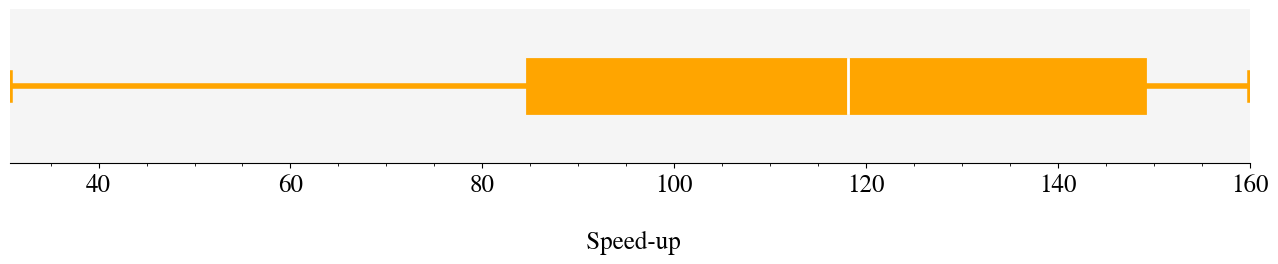

In [56]:
from matplotlib import rcParams

# rcParams['font.family'] = 'Latin Modern Roman 10'
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size'] = 18

# Create Figure and Axes
fig, ax = plt.subplots(figsize=(8*2, 1*2))
ax.set_facecolor('#f5f5f5')  # Using the HEX code for gray

# Create Box Plot with patch_artist=True
box = ax.boxplot(speed_up, vert=False, patch_artist=True,widths=0.35,
                 boxprops=dict(linewidth=2.0, color='orange'),
                 whiskerprops=dict(linewidth=4.0, color='orange'),
                 capprops=dict(linewidth=4.0, color='orange'),
                 medianprops=dict(linewidth=2.0, color='white'),
                 flierprops=dict(marker='.', markerfacecolor='#ffb300', markeredgecolor='#ffb300', markersize=8, linestyle='none'))


ax.set_ylim(0.9, 1.1)

# Set Box Fill Color
for patch in box['boxes']:
    patch.set_facecolor('orange')

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

ax.set_yticklabels([])
ax.set_yticks([])
plt.xlabel('\n Speed-up')
plt.autoscale(enable=True, tight=True)
ax.minorticks_on()

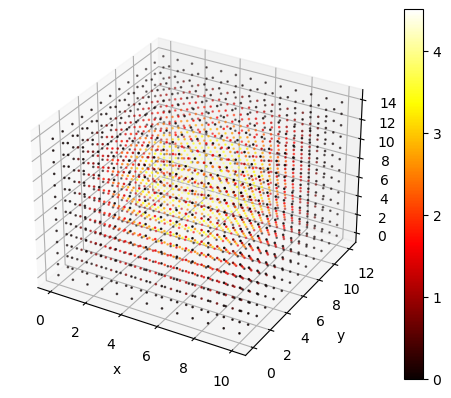

RMS_error is 0.0005300841893942678 %


In [41]:
sol_red = V_sel@NL_solution_p_reduced.reshape(-1,1)  #+pca.mean_.reshape(-1,1)
plot3D(d_test.xi[0], d_test.xi[1], d_test.xi[2], sol_red,hmap=True)
print(f"RMS_error is {np.linalg.norm(sol_red-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")

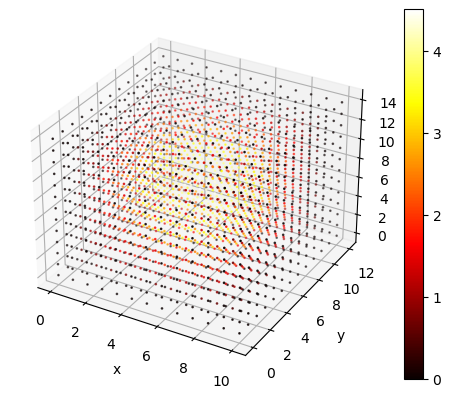



ROM Error without hyperreduction is 1.5224128392307633e-09 %


In [42]:
plot3D(d_test.xi[0], d_test.xi[1], d_test.xi[2], NL_solution_p_fos_test,hmap=True)

print(f"\n\nROM Error without hyperreduction is {np.linalg.norm(V_sel@NL_solution_p_reduced_woh.reshape(-1,1)-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")

 
### Speedups

In [43]:
fos_sim_time = toc_fos - tic_fos
rom_sim_time_woh = toc_rom_woh - tic_rom_woh
rom_sim_time = toc_rom - tic_rom

In [44]:
print(f"speedup without hyperreduction:{fos_sim_time/rom_sim_time_woh}")
print(f"speedup with hyperreduction:{fos_sim_time/(rom_sim_time)}")
# h_total_setup_time = (toc_h_setup_b+toc_h_setup_a) - (tic_h_setup_b+tic_h_setup_a) #this is one time

speedup without hyperreduction:1.2083611328066928
speedup with hyperreduction:175.60065235224417
